In [21]:
# Initial imports
from path import Path
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import psycopg2 as pg

In [22]:
engine = pg.connect("dbname='postgres' user='postgres' host='database-final.cjdbapst3wjf.us-east-1.rds.amazonaws.com' port='5432' password='FinalProject05'")
Contributions = pd.read_sql('select * from merged_2017', con=engine)
Contributions.head()
Contributions.dropna()

,election,candidateid,candidatename,date,contributiontype,city,state,zipcode,amount,matchamt,prevamt,totalamount,expenditure_amount,purposecode,purpose
0,2017,326,"Bill,de Blasio",2017-08-14,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,518,Office Expenses,Office Expenses
1,2017,326,"Bill,de Blasio",2017-09-21,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,1041,Office Expenses,Office Expenses
2,2017,326,"Bill,de Blasio",2017-12-29,Corporation,Brooklyn,NY,11201,0.0,0,0.0,0.0,1500,Office Rent,Office Rent
3,2017,2055,"Roque,De La Fuente",2017-07-14,Corporation,New York,NY,10025,0.0,0,0.0,0.0,6000,Professional Services,Prof. Srvcs.
4,2017,2055,"Roque,De La Fuente",2017-06-09,Corporation,New York,NY,10025,0.0,0,0.0,0.0,6000,Professional Services,Prof. Srvcs.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3789,2017,2071,"Nicole,Malliotakis",2017-11-04,Individual,Astoria,NY,11102,0.0,0,0.0,0.0,54,Advance Repayment,Advance Repaymnt
3790,2017,2071,"Nicole,Malliotakis",2017-11-08,Individual,Astoria,NY,11102,0.0,0,0.0,0.0,125,Fundraising,Fundraising
3791,2017,326,"Bill,de Blasio",2016-09-08,Individual,New York,NY,10021,0.0,0,0.0,0.0,239,Other,Other: explntion
3792,2017,326,"Bill,de Blasio",2016-12-27,Individual,New York,NY,10021,0.0,0,0.0,0.0,239,Other,Other: explntion


In [23]:
Contributions_df = Contributions.drop(columns=['election','prevamt'])
total_groupby = Contributions_df.groupby(['candidatename']).sum(['totalamount']).sort_values('totalamount',ascending=False)
Contributions_df['zipcode'] = Contributions_df['zipcode'].apply(str)

In [24]:
Contributions_df = Contributions_df.groupby(['zipcode','date','contributiontype','city','state']).sum('totalamount')

In [25]:
Contributions_df.head()

amount  matchamt  \
zipcode date       contributiontype city     state                        
0       2016-11-15  Marcia          Q        Rosedale     0.0       100   
        2016-12-16 Individual       Weston   CT         175.0         0   
        2017-01-07 Individual       NYC      NY          10.0         0   
        2017-01-11 Individual       BRONX    NY          10.0        10   
                                    New York NY          10.0        10   

                                                       totalamount  \
zipcode date       contributiontype city     state                   
0       2016-11-15  Marcia          Q        Rosedale          0.0   
        2016-12-16 Individual       Weston   CT              175.0   
        2017-01-07 Individual       NYC      NY               10.0   
        2017-01-11 Individual       BRONX    NY               20.0   
                                    New York NY               20.0   

                                                       expenditure_amount  
zipcode date       contributiontype city     state                         
0       2016-11-15  Marcia          Q        Rosedale                   0  
        2016-12-16 Individual       Weston   CT                         0  
        2017-01-07 Individual       NYC      NY                         0  
        2017-01-11 Individual       BRONX    NY                         0  
                                    New York NY                         0

In [26]:
Contributions_df = Contributions_df.reset_index()
Contributions_df['contributiontype'].unique()

array([' Marcia', 'Individual', 'Corporation',
       'Political Action Committee', 'Labor Union', 'Candidate Committee',
       'Other', 'Limited Liability Company', 'Party Committee',
       'Candidate', 'Candidate Family'], dtype=object)

In [27]:
from sklearn.preprocessing import LabelEncoder
Contributions_df_enc = Contributions_df.copy()
le = LabelEncoder()
Contributions_df_enc['date'] = le.fit_transform(Contributions_df['date'])
Contributions_df_enc['contributiontype'] = le.fit_transform(Contributions_df['contributiontype'])
Contributions_df_enc['city'] = le.fit_transform(Contributions_df['city'])
Contributions_df_enc['state'] = le.fit_transform(Contributions_df['state'])
Contributions_df_enc['zipcode'] = le.fit_transform(Contributions_df['zipcode'])
Contributions_df_enc.head()

,zipcode,date,contributiontype,city,state,amount,matchamt,totalamount,expenditure_amount
0,0,405,0,1009,41,0.0,100,0.0,0
1,0,436,5,1370,7,175.0,0,175.0,0
2,0,458,5,793,34,10.0,0,10.0,0
3,0,462,5,76,34,10.0,10,20.0,0
4,0,462,5,828,34,10.0,10,20.0,0


In [28]:
X = Contributions_df_enc.drop('totalamount',axis = 1)
y = Contributions_df_enc['totalamount']
Contributions_df_enc.nunique()

zipcode               1616
date                   812
contributiontype        11
city                  1478
state                   53
amount                 725
matchamt               346
totalamount           1188
expenditure_amount     888
dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=79)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [31]:
regr = RandomForestRegressor()

In [32]:
regr.fit(X_train, y_train)

RandomForestRegressor()

In [33]:
y_pred = regr.predict(X_test)
print(len(y_pred))

5608


In [34]:
from sklearn.metrics import r2_score
r_squared = r2_score(y_test, y_pred)

0.9175625646742039


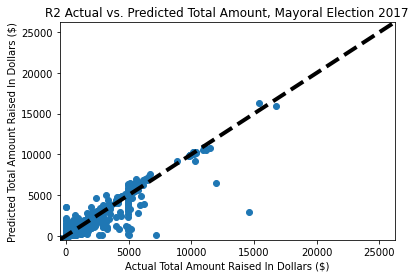

In [35]:
print(r_squared)
plt.scatter(y_test,y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Actual Total Amount Raised In Dollars ($)')
plt.ylabel('Predicted Total Amount Raised In Dollars ($)')
plt.title('R2 Actual vs. Predicted Total Amount, Mayoral Election 2017')
plt.xlim(y.min(), y.max())
plt.ylim(y.min(), y.max())
plt.savefig('../Resources/Predicted_Total_Amount_Regression_2017.png')

In [36]:
pred_df = X_test
pred_df['Predicted Total Amount'] = y_pred

/Users/Abir/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
pred_df.isnull().sum()

zipcode                   0
date                      0
contributiontype          0
city                      0
state                     0
amount                    0
matchamt                  0
expenditure_amount        0
Predicted Total Amount    0
dtype: int64

In [38]:
pred_graph = pred_df.groupby('zipcode').sum('redicted Total Amount').sort_values(by=['Predicted Total Amount'],ascending=True)

In [39]:
pred_graph = pred_graph.reset_index()
pred_graph

,zipcode,date,contributiontype,city,state,amount,matchamt,expenditure_amount,Predicted Total Amount
0,1037,2970,16,948,64,0.00,0,3069840,0.000000
1,730,2103,12,3960,63,0.00,0,274,0.000000
2,505,727,4,249,34,0.00,0,2047,0.000000
3,784,622,4,46,12,0.00,0,2500,0.000000
4,971,334,4,183,47,0.00,0,249,0.000000
...,...,...,...,...,...,...,...,...,...
878,61,40128,345,56111,2312,34053.00,7048,3357,49915.260801
879,248,25294,234,7682,1564,46232.50,5382,619,59898.662500
880,12,27620,251,39601,1632,52225.00,4200,2620,60796.970000
881,22,24544,204,33948,1394,52797.00,7012,85,66257.644399


In [40]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

346.6569741703083